In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
df = pd.read_csv('./input/teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


In [4]:
df['custcat'].value_counts()

custcat
3    281
1    266
4    236
2    217
Name: count, dtype: int64

Виділяємо ознаки та цільову змінну

In [5]:
X = df.drop('custcat', axis=1) 
y = df['custcat']

Виконуємо стандартизацію та розділяємо дані на навчальний набіл і тестовий

In [9]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X.astype(float))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.decomposition import PCA

PCA дозволяє зменшити розмірність даних, зберігаючи при цьому найважливішу інформацію. Це спрощує візуалізацію даних і може підвищити продуктивність деяких алгоритмів машинного навчання. Тому ми зведемо дані до 2-х вимірів, щоб їх можна було легше відобразити на графіках.

In [11]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import time

In [20]:
def train_evaluate_knn(metric, k, X_train, X_test, y_train, y_test):
    print(f'\nKNN з метрикою {metric.capitalize()} та k = {k}')

    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

    start_time = time.time()
    knn.fit(X_train, y_train)
    end_time = time.time()

    y_pred = knn.predict(X_test)

    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    training_time = end_time - start_time

    print_metrics(recall, f1, accuracy, training_time)
    
    return y_pred, training_time, recall, f1, accuracy

def print_metrics(recall, f1, accuracy, training_time):
    print(f'Повнота (Recall): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Точність (Accuracy): {accuracy:.4f}')
    print(f'Час навчання: {training_time:.4f} сек')

In [21]:
def plot_combined_visualization(y_test, y_pred, X_test_pca, metric, k):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False, ax=axs[0])
    axs[0].set_title(f'Матриця помилок (KNN, {metric.capitalize()}, k = {k})')
    axs[0].set_xlabel('Предиктована категорія')
    axs[0].set_ylabel('Фактична категорія')

    scatter = axs[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', alpha=0.7)
    axs[1].set_title(f'Візуалізація кластерів (KNN, {metric.capitalize()}, k = {k})')
    axs[1].set_xlabel('PCA Компонента 1')
    axs[1].set_ylabel('PCA Компонента 2')
    fig.colorbar(scatter, ax=axs[1], label='Предиктована категорія')

    plt.tight_layout()
    plt.show()

In [22]:
def plot_k_value_comparison(results, metric):
    k_vals = []
    accuracies = []
    recalls = []
    f1_scores = []

    for (m, k), metrics in results.items():
        if m == metric:
            k_vals.append(k)
            accuracies.append(metrics['accuracy'])
            recalls.append(metrics['recall'])
            f1_scores.append(metrics['f1'])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(k_vals, accuracies, label='Accuracy', marker='o', linestyle='-')
    ax.plot(k_vals, recalls, label='Recall', marker='o', linestyle='--')
    ax.plot(k_vals, f1_scores, label='F1 Score', marker='o', linestyle='-.')
    
    ax.set_xlabel('K Value')
    ax.set_ylabel('Score')
    ax.set_title(f'Порівняння метрик для метрики {metric.capitalize()}')
    ax.legend()
    plt.grid(True)
    plt.show()

In [23]:
def run_knn_with_metrics(metrics, k_values, X_train, X_test, y_train, y_test, X_test_pca):
    results = {}

    for metric in metrics:
        for k in k_values:
            y_pred, training_time, recall, f1, accuracy = train_evaluate_knn(metric, k, X_train, X_test, y_train, y_test)

            results[(metric, k)] = {
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy,
                'training_time': training_time
            }

            print(classification_report(y_test, y_pred))
            plot_combined_visualization(y_test, y_pred, X_test_pca, metric, k)

        plot_k_value_comparison(results, metric)

    return results

In [24]:
def find_best_knn(results):
    best_score = 0
    best_params = None
    for (metric, k), metrics in results.items():
        if metrics['accuracy'] > best_score:
            best_score = metrics['accuracy']
            best_params = (metric, k)
    print(f'\nНайкраща модель: метрика = {best_params[0]}, k = {best_params[1]}, точність = {best_score:.4f}')
    return best_params, best_score


KNN з метрикою Euclidean та k = 3
Повнота (Recall): 0.3495
F1 Score: 0.3463
Точність (Accuracy): 0.3650
Час навчання: 0.0041 сек
              precision    recall  f1-score   support

           1       0.39      0.52      0.44        60
           2       0.28      0.28      0.28        39
           3       0.43      0.38      0.40        55
           4       0.31      0.22      0.26        46

    accuracy                           0.36       200
   macro avg       0.35      0.35      0.35       200
weighted avg       0.36      0.36      0.36       200



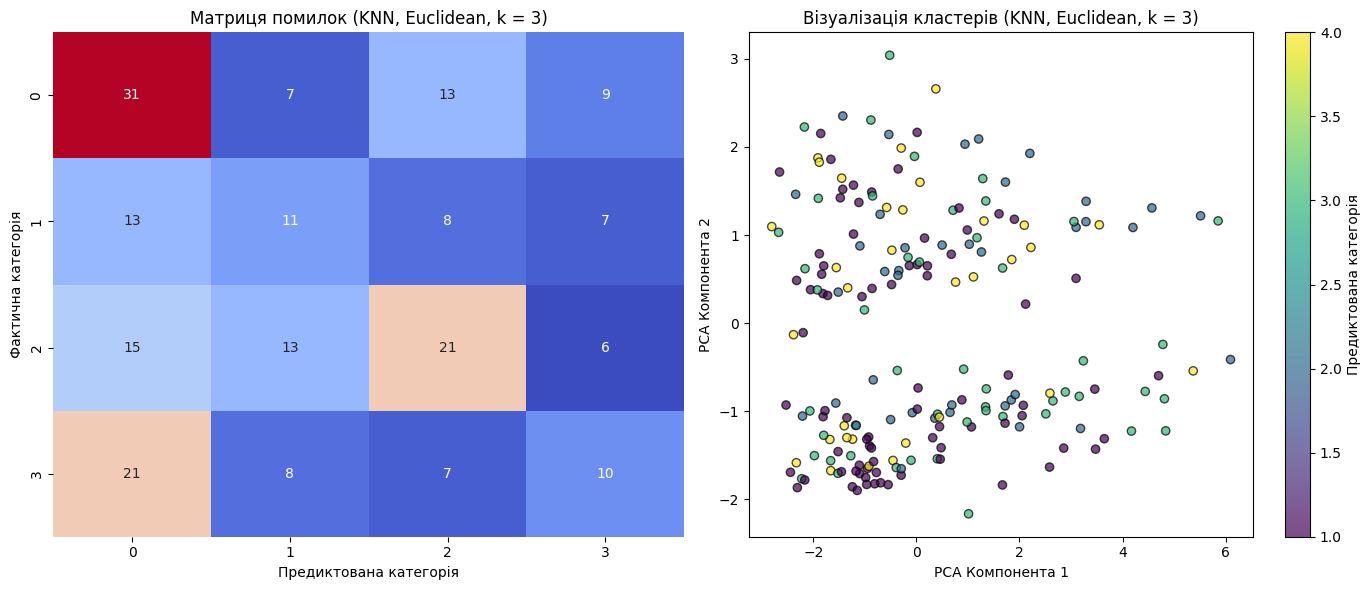


KNN з метрикою Euclidean та k = 5
Повнота (Recall): 0.3166
F1 Score: 0.3143
Точність (Accuracy): 0.3300
Час навчання: 0.0006 сек
              precision    recall  f1-score   support

           1       0.37      0.48      0.42        60
           2       0.22      0.26      0.24        39
           3       0.34      0.31      0.32        55
           4       0.38      0.22      0.28        46

    accuracy                           0.33       200
   macro avg       0.33      0.32      0.31       200
weighted avg       0.34      0.33      0.32       200



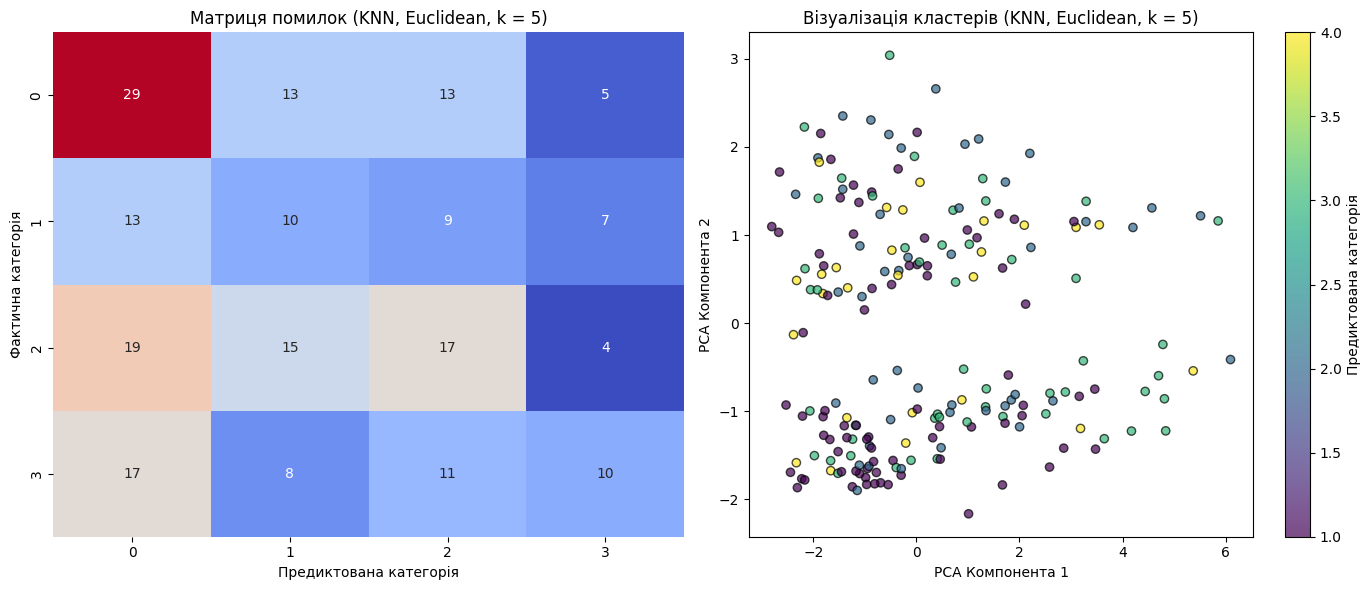


KNN з метрикою Euclidean та k = 7
Повнота (Recall): 0.3105
F1 Score: 0.3042
Точність (Accuracy): 0.3300
Час навчання: 0.0006 сек
              precision    recall  f1-score   support

           1       0.35      0.47      0.40        60
           2       0.24      0.21      0.22        39
           3       0.40      0.42      0.41        55
           4       0.23      0.15      0.18        46

    accuracy                           0.33       200
   macro avg       0.31      0.31      0.30       200
weighted avg       0.32      0.33      0.32       200



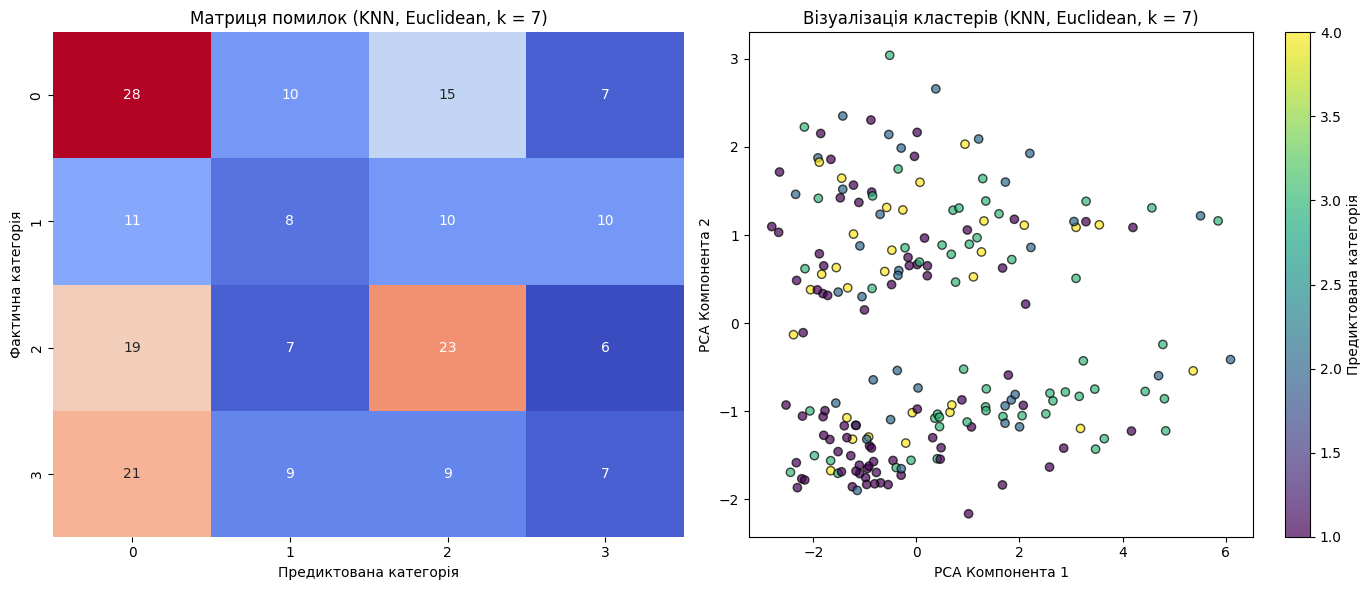


KNN з метрикою Euclidean та k = 9
Повнота (Recall): 0.3126
F1 Score: 0.3088
Точність (Accuracy): 0.3300
Час навчання: 0.0007 сек
              precision    recall  f1-score   support

           1       0.34      0.42      0.38        60
           2       0.25      0.21      0.23        39
           3       0.42      0.45      0.44        55
           4       0.22      0.17      0.20        46

    accuracy                           0.33       200
   macro avg       0.31      0.31      0.31       200
weighted avg       0.32      0.33      0.32       200



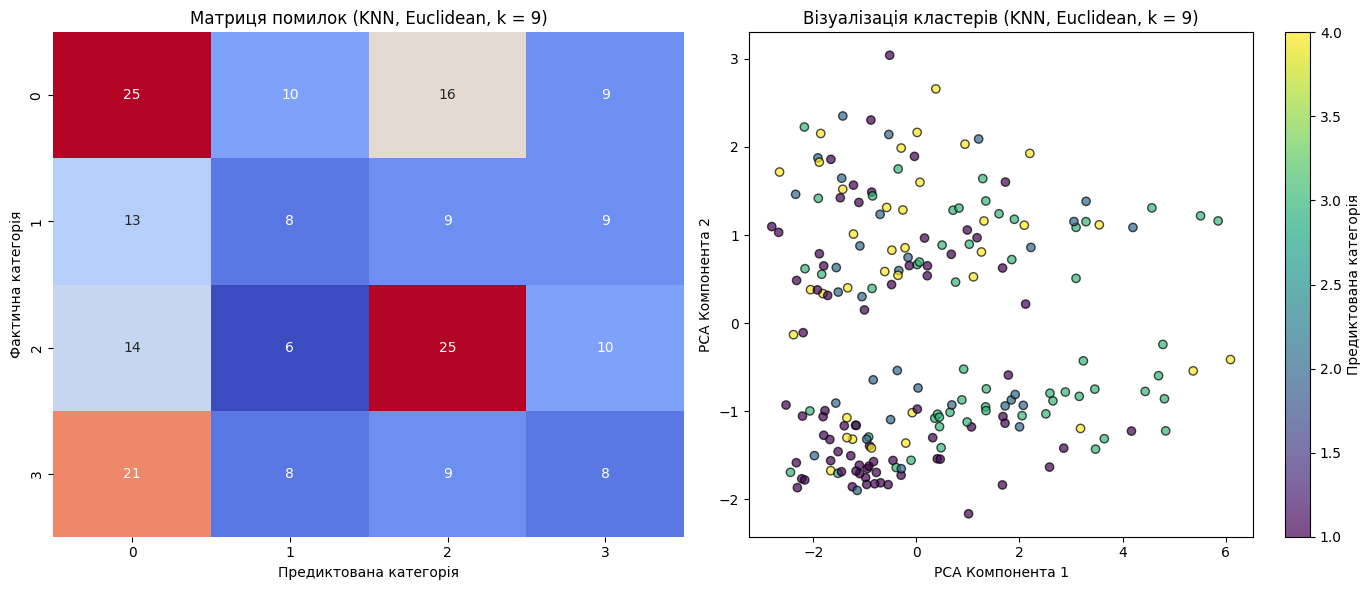

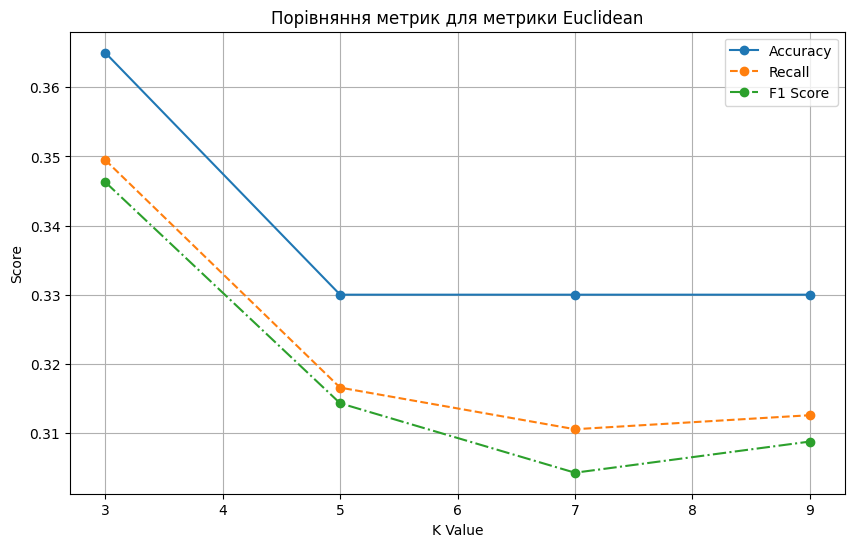


KNN з метрикою Manhattan та k = 3
Повнота (Recall): 0.3178
F1 Score: 0.3135
Точність (Accuracy): 0.3400
Час навчання: 0.0015 сек
              precision    recall  f1-score   support

           1       0.36      0.50      0.42        60
           2       0.19      0.15      0.17        39
           3       0.44      0.40      0.42        55
           4       0.29      0.22      0.25        46

    accuracy                           0.34       200
   macro avg       0.32      0.32      0.31       200
weighted avg       0.33      0.34      0.33       200



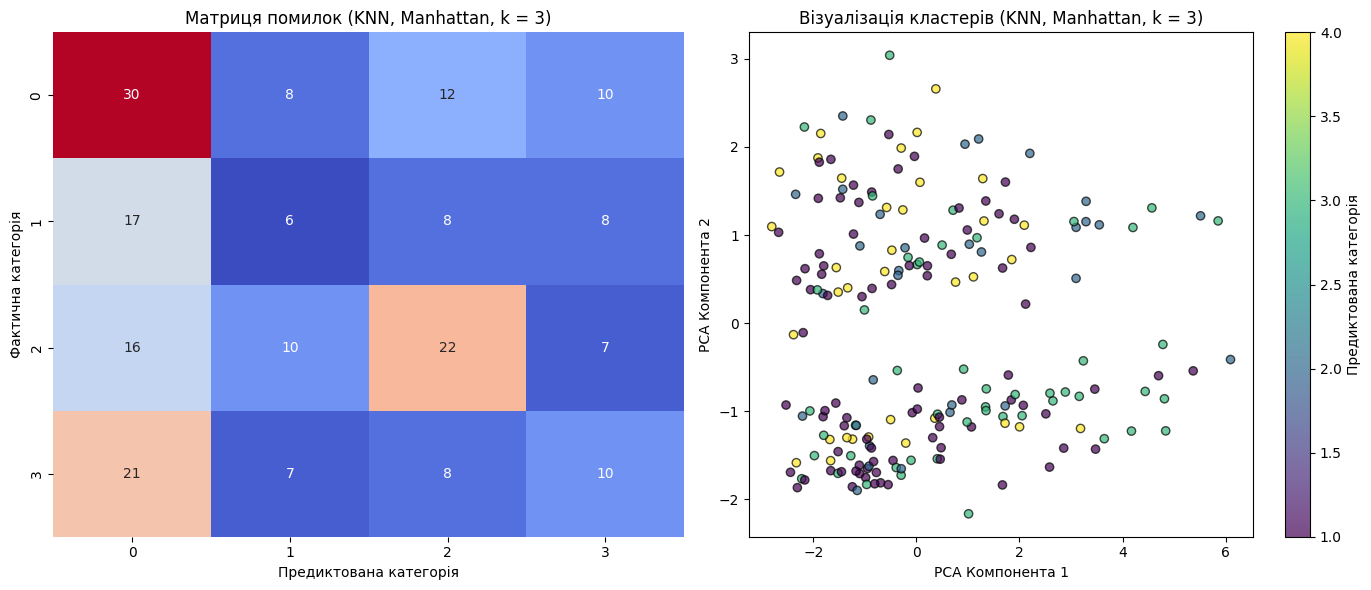


KNN з метрикою Manhattan та k = 5
Повнота (Recall): 0.3076
F1 Score: 0.3060
Точність (Accuracy): 0.3250
Час навчання: 0.0007 сек
              precision    recall  f1-score   support

           1       0.38      0.43      0.40        60
           2       0.17      0.18      0.17        39
           3       0.39      0.40      0.39        55
           4       0.30      0.22      0.25        46

    accuracy                           0.33       200
   macro avg       0.31      0.31      0.31       200
weighted avg       0.32      0.33      0.32       200



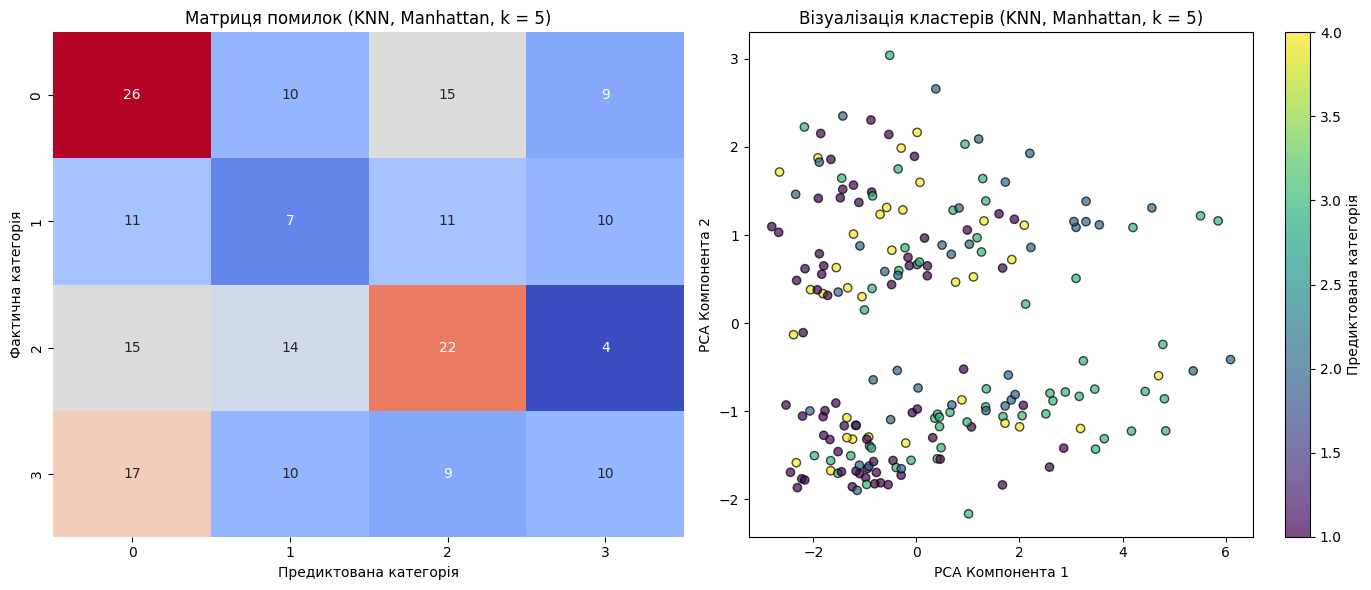


KNN з метрикою Manhattan та k = 7
Повнота (Recall): 0.2903
F1 Score: 0.2893
Точність (Accuracy): 0.3050
Час навчання: 0.0009 сек
              precision    recall  f1-score   support

           1       0.31      0.35      0.33        60
           2       0.16      0.15      0.16        39
           3       0.39      0.42      0.40        55
           4       0.30      0.24      0.27        46

    accuracy                           0.30       200
   macro avg       0.29      0.29      0.29       200
weighted avg       0.30      0.30      0.30       200



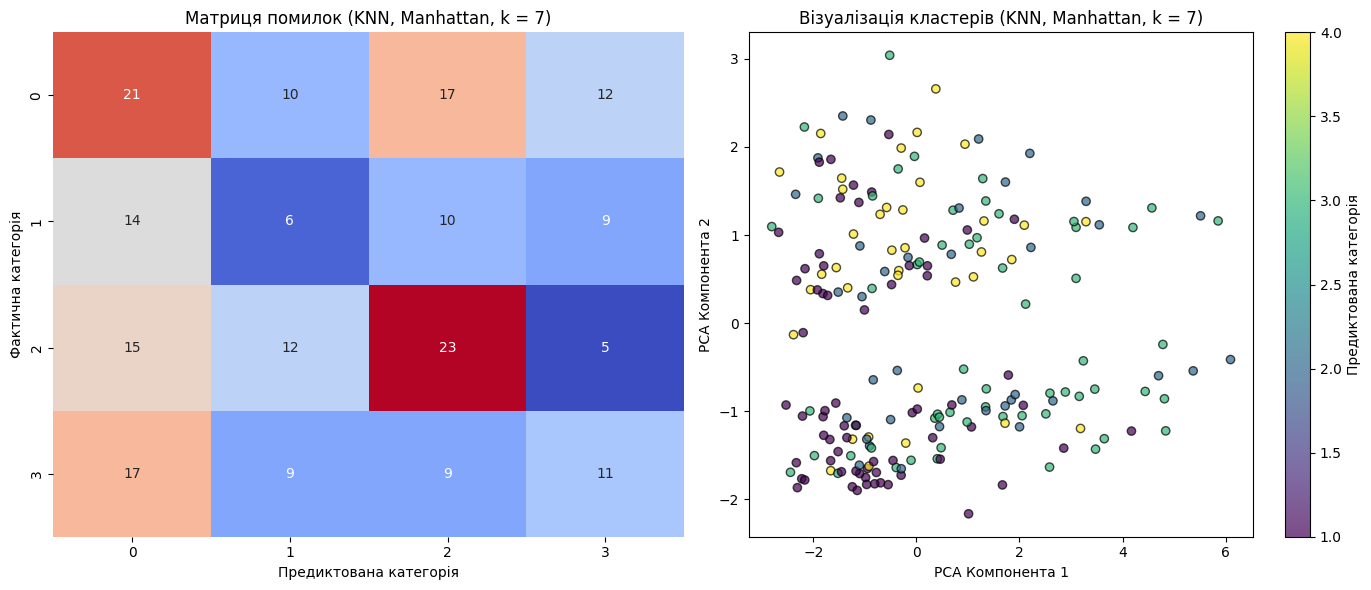


KNN з метрикою Manhattan та k = 9
Повнота (Recall): 0.2875
F1 Score: 0.2827
Точність (Accuracy): 0.3050
Час навчання: 0.0006 сек
              precision    recall  f1-score   support

           1       0.32      0.35      0.33        60
           2       0.16      0.13      0.14        39
           3       0.37      0.45      0.41        55
           4       0.29      0.22      0.25        46

    accuracy                           0.30       200
   macro avg       0.28      0.29      0.28       200
weighted avg       0.29      0.30      0.30       200



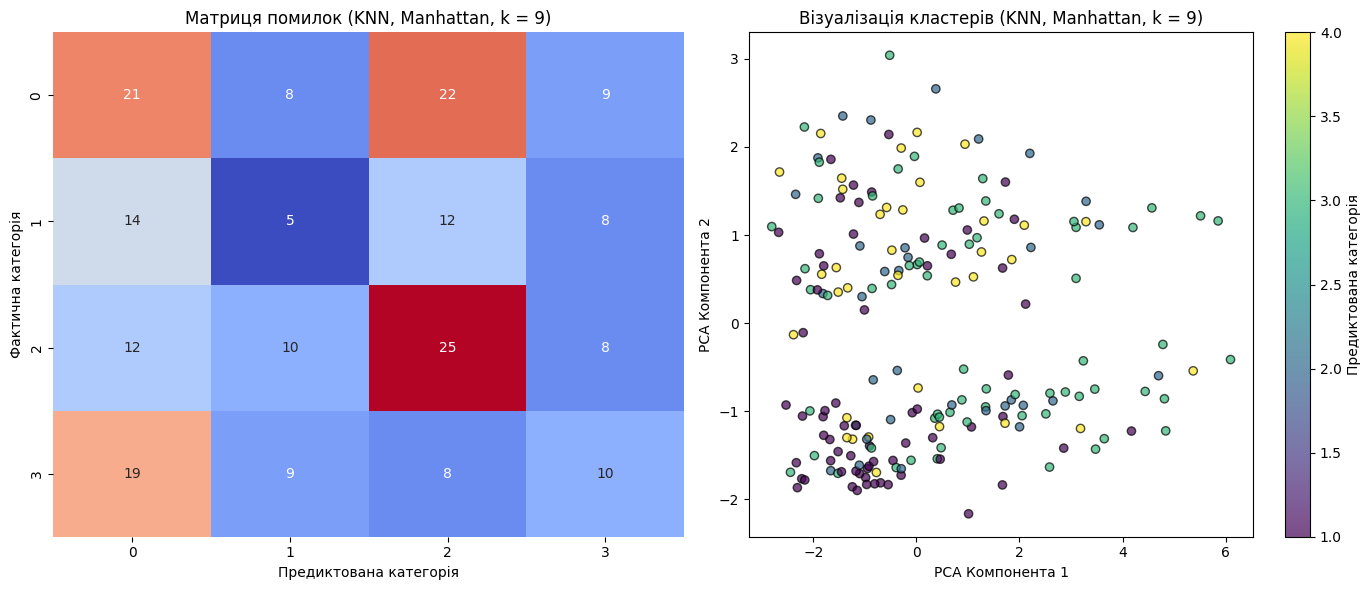

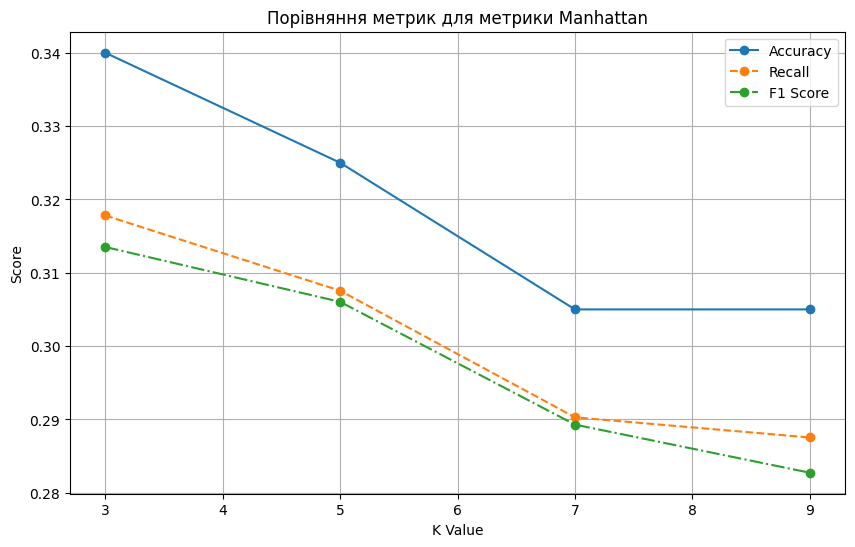


KNN з метрикою Minkowski та k = 3
Повнота (Recall): 0.3495
F1 Score: 0.3463
Точність (Accuracy): 0.3650
Час навчання: 0.0008 сек
              precision    recall  f1-score   support

           1       0.39      0.52      0.44        60
           2       0.28      0.28      0.28        39
           3       0.43      0.38      0.40        55
           4       0.31      0.22      0.26        46

    accuracy                           0.36       200
   macro avg       0.35      0.35      0.35       200
weighted avg       0.36      0.36      0.36       200



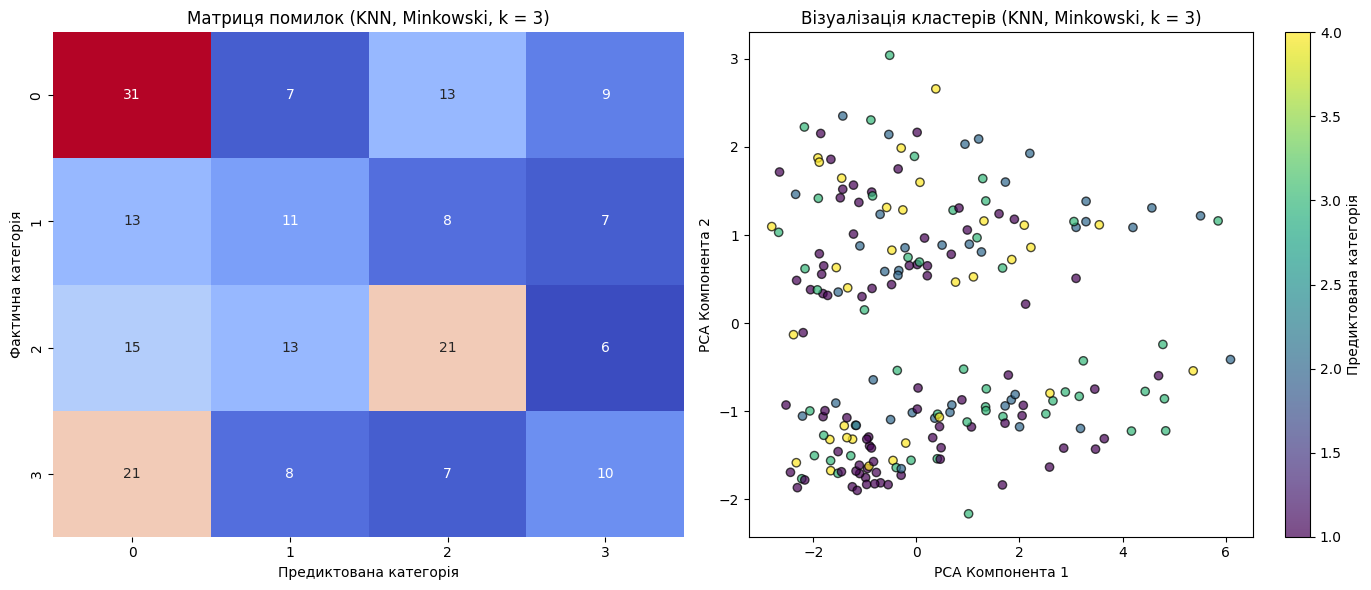


KNN з метрикою Minkowski та k = 5
Повнота (Recall): 0.3166
F1 Score: 0.3143
Точність (Accuracy): 0.3300
Час навчання: 0.0007 сек
              precision    recall  f1-score   support

           1       0.37      0.48      0.42        60
           2       0.22      0.26      0.24        39
           3       0.34      0.31      0.32        55
           4       0.38      0.22      0.28        46

    accuracy                           0.33       200
   macro avg       0.33      0.32      0.31       200
weighted avg       0.34      0.33      0.32       200



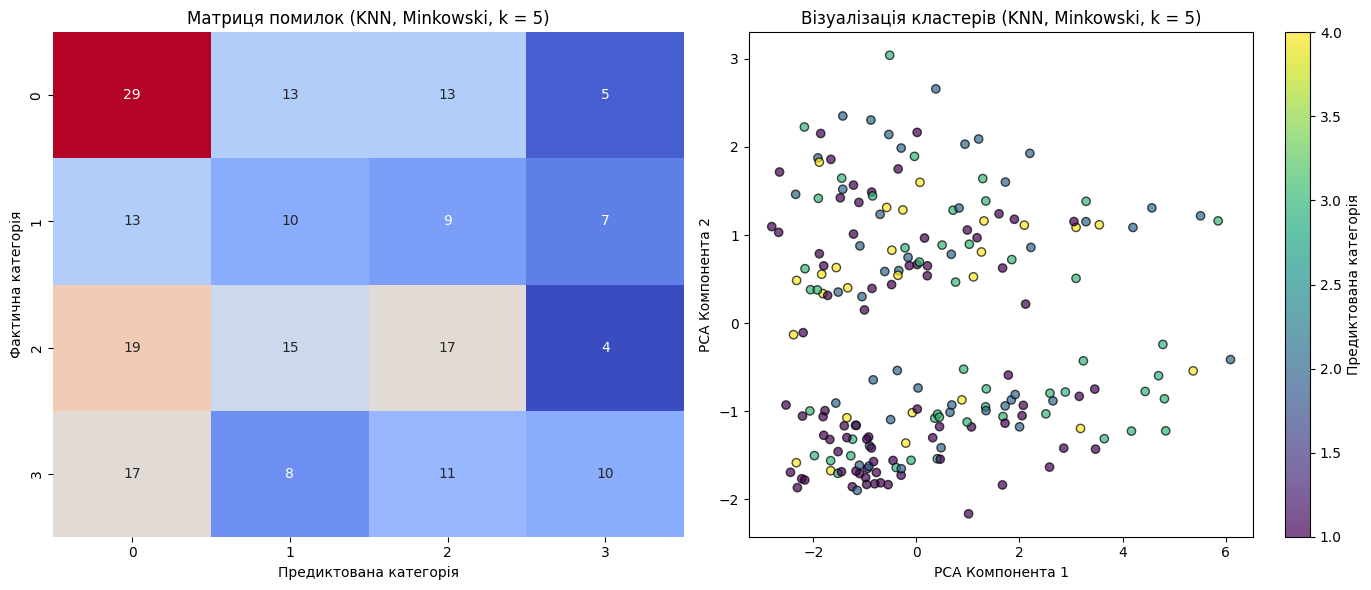


KNN з метрикою Minkowski та k = 7
Повнота (Recall): 0.3105
F1 Score: 0.3042
Точність (Accuracy): 0.3300
Час навчання: 0.0007 сек
              precision    recall  f1-score   support

           1       0.35      0.47      0.40        60
           2       0.24      0.21      0.22        39
           3       0.40      0.42      0.41        55
           4       0.23      0.15      0.18        46

    accuracy                           0.33       200
   macro avg       0.31      0.31      0.30       200
weighted avg       0.32      0.33      0.32       200



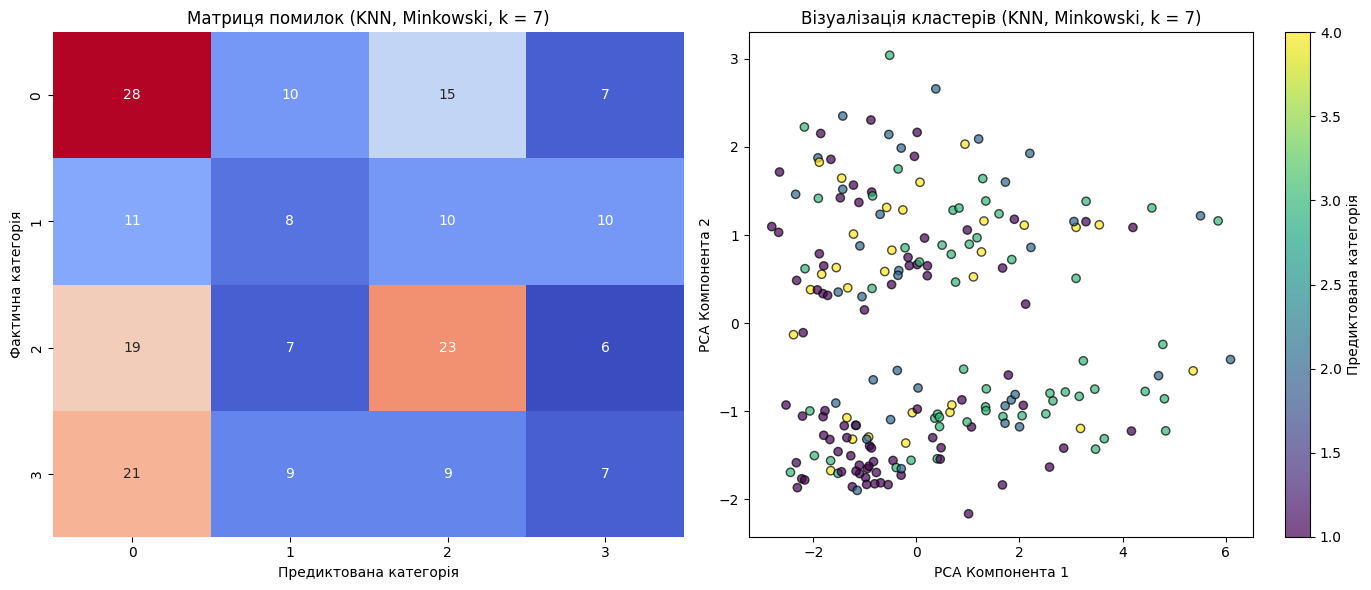


KNN з метрикою Minkowski та k = 9
Повнота (Recall): 0.3126
F1 Score: 0.3088
Точність (Accuracy): 0.3300
Час навчання: 0.0006 сек
              precision    recall  f1-score   support

           1       0.34      0.42      0.38        60
           2       0.25      0.21      0.23        39
           3       0.42      0.45      0.44        55
           4       0.22      0.17      0.20        46

    accuracy                           0.33       200
   macro avg       0.31      0.31      0.31       200
weighted avg       0.32      0.33      0.32       200



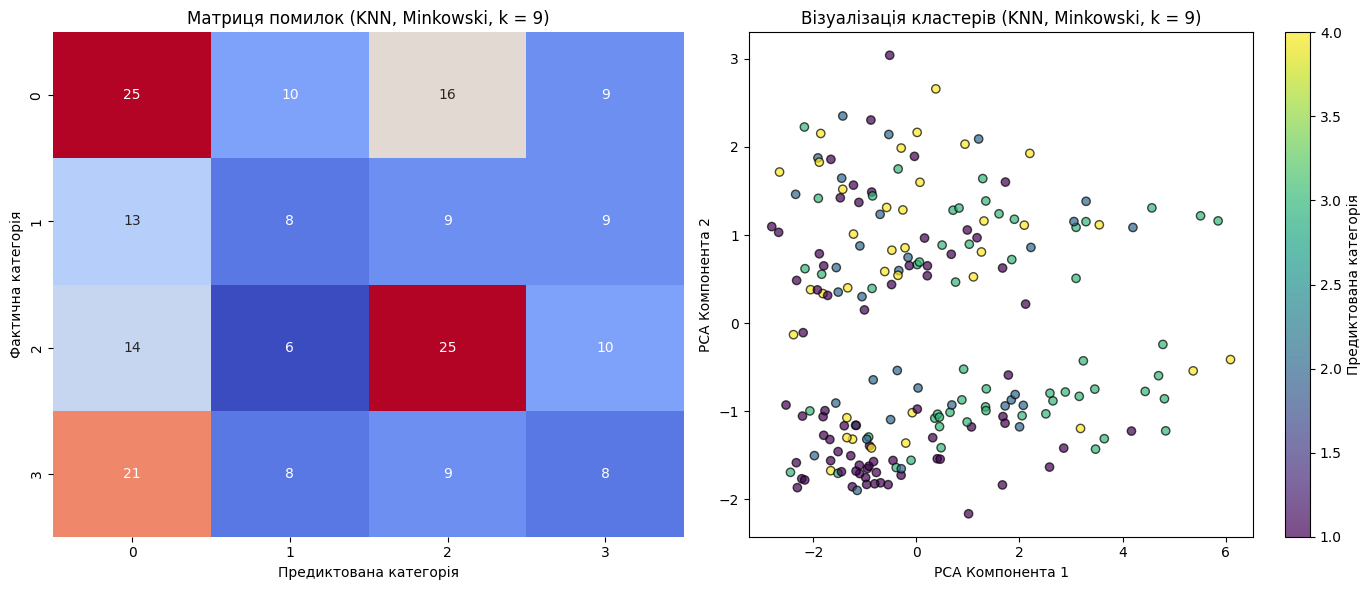

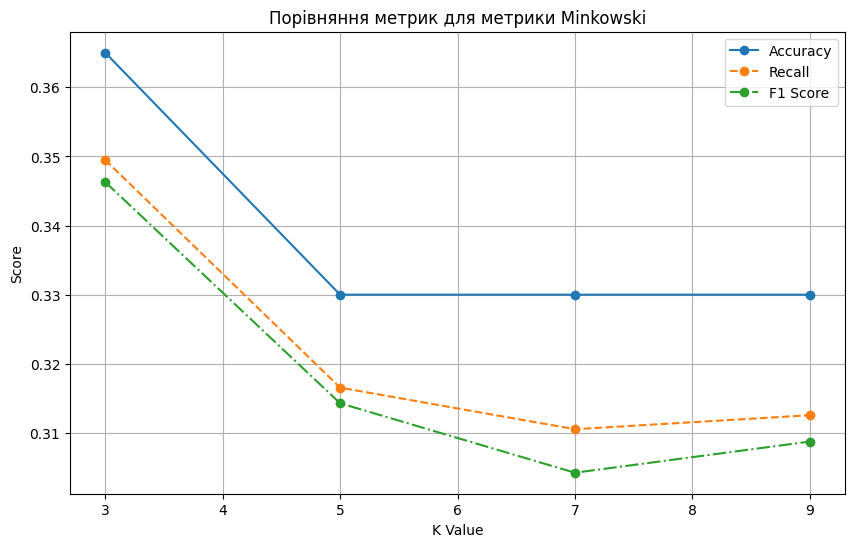


Найкраща модель: метрика = euclidean, k = 3, точність = 0.3650


In [25]:
metrics = ['euclidean', 'manhattan', 'minkowski']
k_values = [3, 5, 7, 9]

results = run_knn_with_metrics(metrics, k_values, X_train, X_test, y_train, y_test, X_test_pca)

best_params, best_score = find_best_knn(results)

# Висновок по дослідженню KNN моделі

## Загальна інформація
Для класифікації використовувалася модель **K-Nearest Neighbors (KNN)** з різними метриками відстаней (Euclidean, Manhattan, Minkowski) і різними значеннями кількості сусідів **k** (3, 5, 7, 9). Мета дослідження полягала в тому, щоб знайти найкращу комбінацію метрики та кількості сусідів, яка забезпечить найвищу точність для класифікації користувачів у різні категорії.

### Метрика: Euclidean
- **k = 3**:
  - Повнота (Recall): 0.3495
  - F1 Score: 0.3463
  - Точність (Accuracy): 0.3650
  - Час навчання: 0.0041 сек

- **k = 5**:
  - Повнота (Recall): 0.3166
  - F1 Score: 0.3143
  - Точність (Accuracy): 0.3300
  - Час навчання: 0.0006 сек

- **k = 7**:
  - Повнота (Recall): 0.3105
  - F1 Score: 0.3042
  - Точність (Accuracy): 0.3300
  - Час навчання: 0.0006 сек

- **k = 9**:
  - Повнота (Recall): 0.3126
  - F1 Score: 0.3088
  - Точність (Accuracy): 0.3300
  - Час навчання: 0.0007 сек

### Метрика: Manhattan
- **k = 3**:
  - Повнота (Recall): 0.3178
  - F1 Score: 0.3135
  - Точність (Accuracy): 0.3400
  - Час навчання: 0.0015 сек

- **k = 5**:
  - Повнота (Recall): 0.3076
  - F1 Score: 0.3060
  - Точність (Accuracy): 0.3250
  - Час навчання: 0.0007 сек

- **k = 7**:
  - Повнота (Recall): 0.2903
  - F1 Score: 0.2893
  - Точність (Accuracy): 0.3050
  - Час навчання: 0.0009 сек

- **k = 9**:
  - Повнота (Recall): 0.2875
  - F1 Score: 0.2827
  - Точність (Accuracy): 0.3050
  - Час навчання: 0.0006 сек

### Метрика: Minkowski
- **k = 3**:
  - Повнота (Recall): 0.3495
  - F1 Score: 0.3463
  - Точність (Accuracy): 0.3650
  - Час навчання: 0.0008 сек

- **k = 5**:
  - Повнота (Recall): 0.3166
  - F1 Score: 0.3143
  - Точність (Accuracy): 0.3300
  - Час навчання: 0.0007 сек

- **k = 7**:
  - Повнота (Recall): 0.3105
  - F1 Score: 0.3042
  - Точність (Accuracy): 0.3300
  - Час навчання: 0.0007 сек

- **k = 9**:
  - Повнота (Recall): 0.3126
  - F1 Score: 0.3088
  - Точність (Accuracy): 0.3300
  - Час навчання: 0.0006 сек

## Порівняння результатів
- Найвища точність **0.3650** була досягнута при використанні **метрики Euclidean** та **k = 3**.
- В інших випадках з більшими значеннями k та з іншими метриками (Manhattan, Minkowski) спостерігається незначне зниження точності, що свідчить про можливе погіршення здатності моделі розрізняти класи.

### Час навчання
- Час навчання моделі зростає при зменшенні значення k. Наприклад, для **k = 3** час навчання був найбільший (близько 0.0041 сек), тоді як для **k = 5, 7, 9** час був значно меншим (близько 0.0006–0.0009 сек).

## Ширший погляд: Чи підходить KNN для цих даних?

### Обмеження моделі KNN:
1. **Низька точність**:
   - Найвища точність, яку вдалося досягти, становить лише **36.50%** (метрика Euclidean, k=3). Це вказує на те, що модель KNN не дуже добре підходить для класифікації цього набору даних.
   
2. **Дисбаланс класів**:
   - Звертаємо увагу на наявність дисбалансу в класах: наприклад, клас 3 має більше прикладів у порівнянні з іншими. Це може впливати на роботу KNN, оскільки модель може бути більш схильною до прогнозування найбільш поширених класів.

3. **Складність даних**:
   - Виходячи з низької продуктивності моделі, можемо припустити, що дані можуть бути складними для моделей на основі найближчих сусідів, оскільки KNN добре працює, коли групи чітко розділені. Якщо дані є нелінійними або мають складну структуру, KNN може не справлятися з такими викликами.

## Висновки
- **Найкраща модель**: KNN з метрикою **Euclidean** та **k = 3**, що показала найвищу точність **36.50%**.
- **Вплив метрики**: Метрика **Euclidean** продемонструвала найкращі результати у порівнянні з метриками **Manhattan** та **Minkowski**.
- **Вплив k**: Зі збільшенням значення **k** продуктивність моделі (точність, recall, F1) дещо погіршувалася, що може свідчити про зменшення чутливості до локальних патернів у даних.
- **Загальна придатність KNN**: Модель KNN у поточному вигляді має обмежену ефективність для цих даних. Можливо, слід розглянути інші підходи для отримання кращих результатів.
